In [1]:
import pandas as pd
import re
import string

In [2]:
data = pd.read_csv("dataset/hate_speech.tsv", sep='\t',header=None)

In [3]:
data.columns = ["text", "label"]

In [4]:
data.dropna(inplace=True)

In [5]:
data.reset_index(inplace=True)

In [6]:
data.head()

,index,text,label
0,0,Knowing ki Vikas kitna samjhata hai Priyanka a...,no
1,1,I am Muhajir .. Aur mere lye sab se Pehly Paki...,no
2,2,Doctor sab sahi me ke PhD (in hate politics) ...,no
3,3,Poore Desh me Patel OBC me aate Hain sirf gujr...,no
4,4,Sarkar banne ke bad Hindu hit me ek bhi faisla...,yes


In [7]:
def clean(text):
#     text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('','',string.punctuation))
    text = text.lower()
    text = text.strip()
    text = text.translate(str.maketrans('','','1234567890'))
    
    return text

In [8]:
data["text"] = data["text"].apply(clean)

In [9]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop = list(stop)
from string import punctuation
from functools import reduce
import itertools


from collections import Counter
import re
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

%matplotlib inline

In [10]:
data["label"].count()

4578

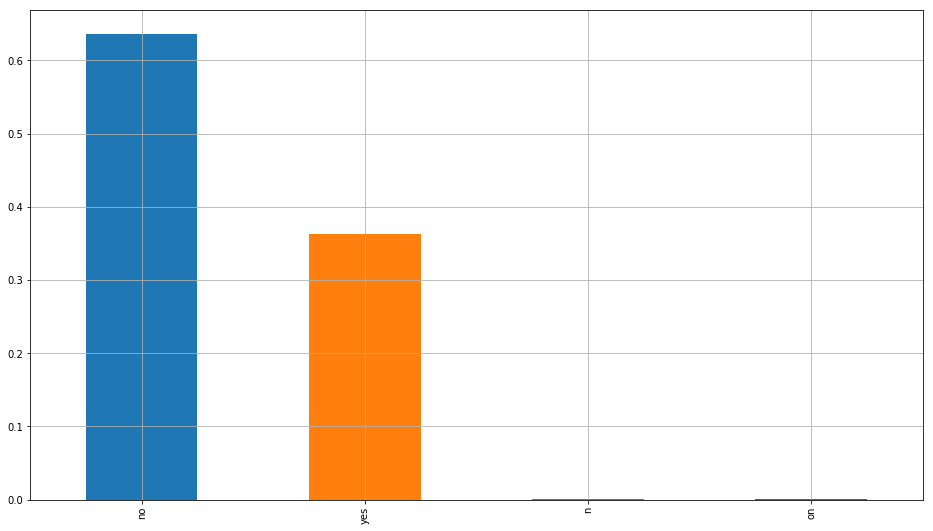

In [11]:
data.label.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

In [12]:
def load_data_and_labels():
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    examples = data['text']
    examples = list(examples)
    examples = [s.strip() for s in examples]
    
    # Split by words
    x_text = examples
    #x_text = [clean_str(sent) for sent in x_text]
    #x_text = [removeNonAscii(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    
    # Generate labels
    y = list(data['label'].map(lambda x : 1 if x=='yes' else 0))
    
#     print("load data and labels:", [len(x_text),len(y)])
    return [x_text, y]

In [13]:
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    
#     print("Vocabulary: ", len(vocabulary), len(vocabulary_inv))
    return [vocabulary, vocabulary_inv]

In [14]:
def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    
#     print("Build input data:", [len(x),len(y)])
    return [x, y]


In [15]:
def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
        
   #  print("Padded sentences: ", len(padded_sentences))
    return padded_sentences

In [16]:
def preprocess_data():
    """
    Loads and preprocessed data for the MR dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences, labels = load_data_and_labels()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
#     print("Preprocess load data:", [len(x),len(y), len(vocabulary), len(vocabulary_inv)])
    return [x, y, vocabulary, vocabulary_inv]

In [17]:
temp = preprocess_data()

In [168]:
sequence_length = 67
n_words = 15292
n_tags = 2

In [169]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [170]:
input = Input(shape=(sequence_length,))

model = Embedding(input_dim=n_words, output_dim=50, input_length=sequence_length)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(model)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(model)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(model)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [171]:
model = Model(input, out)

In [172]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [1]:
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.3, verbose=1)

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

## CNN Model

In [132]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from tensorflow.python.keras.layers.merge import Concatenate
from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.preprocessing import sequence
np.random.seed(0)

In [149]:
# Model Hyperparameters
embedding_dim = 50
filter_sizes = (3, 4, 5)
num_filters = 2
dropout_prob = (0.7, 0.8)
hidden_dims = 20

# Training parameters
batch_size = 20
num_epochs = 50

# Prepossessing parameters
sequence_length = 67
max_words = 15292

In [150]:
def load_data():
    x, y, vocabulary, vocabulary_inv_list = preprocess_data()
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
    
    # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x = x[shuffle_indices]
    y = y[shuffle_indices]
    train_len = int(len(x) * 0.9)
    x_train = x[:train_len]
    y_train = y[:train_len]
    x_test = x[train_len:]
    y_test = y[train_len:]

    return x_train, y_train, x_test, y_test, vocabulary, vocabulary_inv

In [151]:
# Data Preparation
print("Load data...")
x_train, y_train, x_test, y_test, vocabulary, vocabulary_inv = load_data()

# if sequence_length != x_test.shape[1]:
#     print("Adjusting sequence length for actual size")
#     sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

Load data...
x_train shape: (4120, 67)
x_test shape: (458, 67)
Vocabulary Size: 15292


In [152]:
input_shape = (sequence_length,)

model_input = Input(shape=input_shape)

In [153]:
z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)

z = Dropout(dropout_prob[0])(z)

In [154]:
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu",kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(z)
z = Dropout(dropout_prob[0])(z)
model_output = Dense(1, activation="sigmoid")(z)
model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [155]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 67)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 67, 50)       764600      input_16[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 67, 50)       0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 65, 2)        302         dropout_37[0][0]                 
__________________________________________________________________________________________________
conv1d_33 

In [156]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 4120 samples, validate on 458 samples
Epoch 1/50
 - 4s - loss: 1.5381 - acc: 0.5998 - val_loss: 0.7030 - val_acc: 0.6266
Epoch 2/50
 - 3s - loss: 0.6725 - acc: 0.6386 - val_loss: 0.6689 - val_acc: 0.6266
Epoch 3/50
 - 2s - loss: 0.6654 - acc: 0.6386 - val_loss: 0.6672 - val_acc: 0.6266
Epoch 4/50
 - 2s - loss: 0.6625 - acc: 0.6386 - val_loss: 0.6642 - val_acc: 0.6266
Epoch 5/50
 - 2s - loss: 0.6608 - acc: 0.6386 - val_loss: 0.6643 - val_acc: 0.6266
Epoch 6/50
 - 2s - loss: 0.6600 - acc: 0.6386 - val_loss: 0.6641 - val_acc: 0.6266
Epoch 7/50
 - 2s - loss: 0.6589 - acc: 0.6386 - val_loss: 0.6635 - val_acc: 0.6266
Epoch 8/50
 - 2s - loss: 0.6587 - acc: 0.6386 - val_loss: 0.6626 - val_acc: 0.6266
Epoch 9/50
 - 2s - loss: 0.6574 - acc: 0.6383 - val_loss: 0.6660 - val_acc: 0.6266
Epoch 10/50
 - 2s - loss: 0.6582 - acc: 0.6383 - val_loss: 0.6653 - val_acc: 0.6266
Epoch 11/50
 - 2s - loss: 0.6520 - acc: 0.6447 - val_loss: 0.6665 - val_acc: 0.6266
Epoch 12/50
 - 2s - loss: 0.6386 - acc

In [ ]:
# list all data in history
print(history.history.keys())

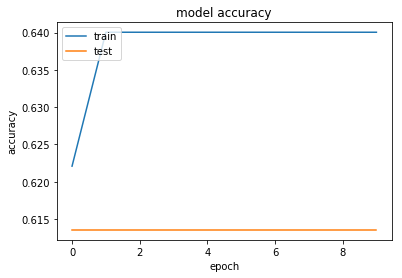

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

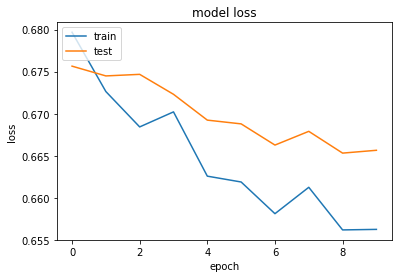

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
test_sentence = "Rape"

In [31]:
def prepare_new_sentence(sentence):
    
    #Load Vocabulary
    _, _, _, _, vocabulary, vocabulary_inv = load_data()
    
    #Data Pre Processing
#     sentence = clean_str(sentence)
#     sentence = removeNonAscii(sentence)
#     sentence = sentence.strip()
    sentence = clean(sentence)
    sentence = sentence.split(" ")
    
    #Padding
    sequence_length = 67
    num_padding = sequence_length - len(sentence)
    sentence = sentence + ["<PAD/>"] * num_padding
    
    #print(sentence)
    
    x_new = np.array([vocabulary[word] for word in sentence])
    
    return x_new

In [32]:
x_new = prepare_new_sentence(test_sentence)

In [33]:
# x_new = x_test[2]

y_new = model.predict(np.array([x_new,]))

print(y_new)

if(np.round(y_new) == 1):
    print("Yes")

else:
    print("No")

[[0.4044397]]
No
